## Training with a Larger Dataset - Cats and Dogs

In the previous lab you trained a classifier with a horses-v-humans dataset. You saw that despite getting great training results, when you tried to do classification with real images, there were many errors, due primarily to overfitting -- where the network  does very well with data that it has previously seen, but poorly with data it hasn't!

In this lab you'll look at a real, and very large dataset, and see the impact this has to avoid overfitting.

In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [3]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

# !wget --no-check-certificate \
#     "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#     -O "/tmp/cats-and-dogs.zip"


'''
# The dataset isn't available on laurencemoroney's site.
# I downloaded the dataset from kaggle,
# Dataset Kaggle Link: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset

# I have created the zip files and uploaded them to the drive.
# Google drive sharing links: https://drive.google.com/file/d/1a3wqKYDUp6LDHMsETP5QUtxpyx6oNhYT/view?usp=sharing
''';


!wget --load-cookies /tmp/cookies.txt \
"https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a3wqKYDUp6LDHMsETP5QUtxpyx6oNhYT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a3wqKYDUp6LDHMsETP5QUtxpyx6oNhYT" \
-O /tmp/cats-and-dogs.zip && rm -rf /tmp/cookies.txt


local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2023-09-23 13:13:57--  https://docs.google.com/uc?export=download&confirm=t&id=1a3wqKYDUp6LDHMsETP5QUtxpyx6oNhYT
Resolving docs.google.com (docs.google.com)... 74.125.201.100, 74.125.201.101, 74.125.201.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.201.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a9bko7q20v2f1tnmj3qo0q3ptu2t689g/1695474825000/04477229989622325732/*/1a3wqKYDUp6LDHMsETP5QUtxpyx6oNhYT?e=download&uuid=b753f3fc-2f22-4df9-b471-829ef2b1565a [following]
--2023-09-23 13:13:57--  https://doc-0o-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a9bko7q20v2f1tnmj3qo0q3ptu2t689g/1695474825000/04477229989622325732/*/1a3wqKYDUp6LDHMsETP5QUtxpyx6oNhYT?e=download&uuid=b753f3fc-2f22-4df9-b471-829ef2b1565a
Resolving doc-0o-18-docs.googleusercontent.com (doc-0o-18-docs.googleusercontent.com)... 142.250.152.132,

In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12491
12470


In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11241
11223
1250
1247


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])


In [9]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22463 images belonging to 2 classes.
Found 2496 images belonging to 2 classes.


In [10]:
# Note that this may take some time.
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

Epoch 1/15
19/90 [=====>........................] - ETA: 35s - loss: 0.7081 - acc: 0.5335

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 [==============================] - 69s 611ms/step - loss: 0.6619 - acc: 0.5962 - val_loss: 0.5773 - val_acc: 0.6940
Epoch 2/15
90/90 [==============================] - 55s 608ms/step - loss: 0.5881 - acc: 0.6840 - val_loss: 0.5705 - val_acc: 0.7067
Epoch 3/15
90/90 [==============================] - 53s 585ms/step - loss: 0.5562 - acc: 0.7129 - val_loss: 0.5028 - val_acc: 0.7527
Epoch 4/15
90/90 [==============================] - 53s 592ms/step - loss: 0.5154 - acc: 0.7408 - val_loss: 0.5102 - val_acc: 0.7420
Epoch 5/15
90/90 [==============================] - 54s 604ms/step - loss: 0.4806 - acc: 0.7650 - val_loss: 0.4463 - val_acc: 0.7773
Epoch 6/15
90/90 [==============================] - 61s 675ms/step - loss: 0.4483 - acc: 0.7867 - val_loss: 0.4307 - val_acc: 0.7973
Epoch 7/15
90/90 [==============================] - 55s 606ms/step - loss: 0.4198 - acc: 0.8050 - val_loss: 0.3768 - val_acc: 0.8107
Epoch 8/15
90/90 [==============================] - 55s 607ms/step - loss: 0.399

<Figure size 640x480 with 0 Axes>

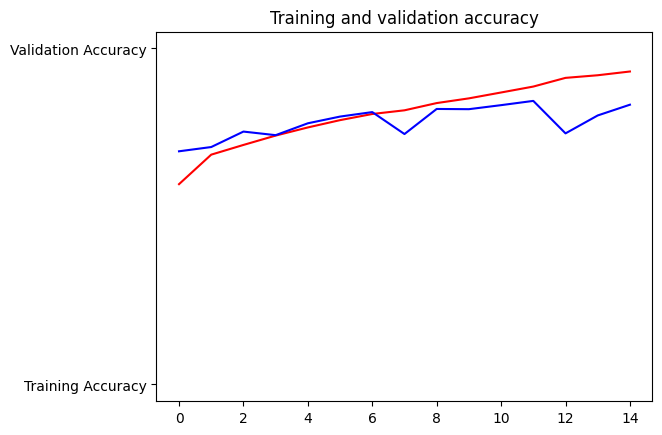

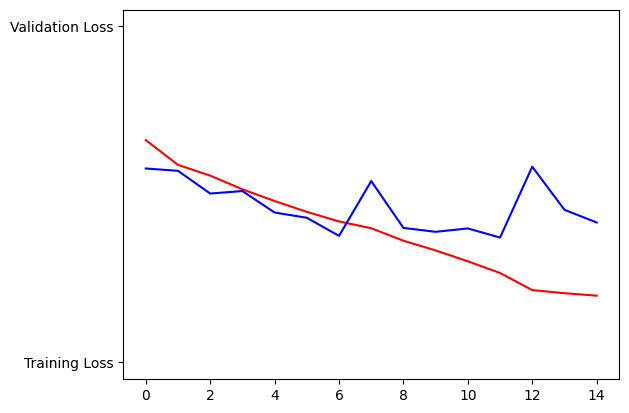

<Figure size 640x480 with 0 Axes>

In [11]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [13]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving  (3).jpg to  (3).jpg
Saving  (4).jpg to  (4).jpg
Saving  (5).jpg to  (5).jpg
Saving  (6).jpg to  (6).jpg
Saving  (7).jpg to  (7).jpg
1/1 [==============================] - 0s 215ms/step
[1.]
 (3).jpg is a dog
1/1 [==============================] - 0s 29ms/step
[1.]
 (4).jpg is a dog
1/1 [==============================] - 0s 21ms/step
[0.]
 (5).jpg is a cat
1/1 [==============================] - 0s 26ms/step
[1.]
 (6).jpg is a dog
1/1 [==============================] - 0s 21ms/step
[1.]
 (7).jpg is a dog
